# Analyse comparative des données générées vs données de base
Ce notebook permet d'analyser et de comparer les données générées (`augmented.jsonl`) avec les données de base (`intent_mapped_with_elo.jsonl`).

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import json
sns.set(style='whitegrid')

In [2]:
# Charger les données de base
base_path = '../intent_mapped_with_elo.jsonl'
base_data = []
with open(base_path, 'r', encoding='utf-8') as f:
    for line in f:
        base_data.append(json.loads(line))
df_base = pd.DataFrame(base_data)
df_base.head()

,id,dataset,prompt,response,intent_disc,intent_cont,intent_source,original_label,language
0,URS_000000,URS,如何提高民营企业的市场竞争力？,提高民营企业的市场竞争力，可以从以下几个方面入手：\n\n1. **创新与研发**：持续投入...,2,0.062,mapped_URS,Ask_for_Advice,CN
1,URS_000001,URS,跳舞和骑车时哪个更合适，Apple Watch还是Oura Ring？,对于跳舞和骑车这两项活动，Apple Watch会比Oura Ring更加合适。理由如下：\...,2,0.062,mapped_URS,Ask_for_Advice,CN
2,URS_000002,URS,日常补充剂的推荐摄入量是多少？,推荐的日常补充剂摄入量因年龄、性别、健康状况和特定需求而异。以下是几种常见补充剂的大致指导量...,2,0.062,mapped_URS,Ask_for_Advice,CN
3,URS_000003,URS,如何在工作中提高与同事的沟通效率？,提高工作中与同事的沟通效率，可以通过以下几种方式实现：\n\n1. **明确沟通目标**：在...,2,0.062,mapped_URS,Ask_for_Advice,CN
4,URS_000004,URS,如何快速提高英语听力能力？,要快速提高英语听力能力，可以采取以下策略：\n\n1. **定期练习**：每天安排特定时间用...,2,0.062,mapped_URS,Ask_for_Advice,CN


In [3]:
# Charger les données générées
gen_path = '../augmented.jsonl'
gen_data = []
with open(gen_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            gen_data.append(json.loads(line))
        except Exception:
            pass  # ignorer les lignes non valides
df_gen = pd.DataFrame(gen_data)
df_gen.head()

,prompt,dataset,intent_disc,intent_cont
0,Why is sweat excessively salty in cystic fibro...,augmented,0,-0.225
1,How long can certain snakes survive without food?,augmented,0,-0.239
2,Which organism shares a closer evolutionary re...,augmented,1,-0.133
3,I am excited to apply for the project manager ...,augmented,1,0.011
4,Summarize the Universal Basic Foods program de...,augmented,1,0.011


In [4]:
# Nettoyer et préparer les données
def clean_df(df):
    # Harmoniser les colonnes communes
    cols = ['prompt', 'intent_disc', 'intent_cont']
    df = df.copy()
    for col in cols:
        if col not in df.columns:
            df[col] = np.nan
    # Convertir les types
    df['intent_disc'] = pd.to_numeric(df['intent_disc'], errors='coerce')
    df['intent_cont'] = pd.to_numeric(df['intent_cont'], errors='coerce')
    return df[cols]
df_base_clean = clean_df(df_base)
df_gen_clean = clean_df(df_gen)
print('Données de base :')
print(df_base_clean.info())
print('Données générées :')
print(df_gen_clean.info())

Données de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prompt       2082 non-null   object 
 1   intent_disc  2082 non-null   int64  
 2   intent_cont  2082 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 48.9+ KB
None
Données générées :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prompt       1592 non-null   object 
 1   intent_disc  1592 non-null   int64  
 2   intent_cont  1592 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.4+ KB
None


In [5]:
# Statistiques descriptives
print('Statistiques descriptives - Données de base')
display(df_base_clean.describe())
print('Statistiques descriptives - Données générées')
display(df_gen_clean.describe())

Statistiques descriptives - Données de base


,intent_disc,intent_cont
count,2082.000000,2082.000000
mean,1.479827,-0.026732
std,1.088062,0.136954
min,0.000000,-0.239000
25%,0.000000,-0.225000
50%,2.000000,0.027000
75%,2.000000,0.062000
max,4.000000,0.262000


Statistiques descriptives - Données générées


,intent_disc,intent_cont
count,1592.000000,1592.000000
mean,2.302764,0.041217
std,1.475138,0.133036
min,0.000000,-0.239000
25%,1.000000,-0.031341
50%,3.000000,0.133000
75%,4.000000,0.141000
max,4.000000,0.262000


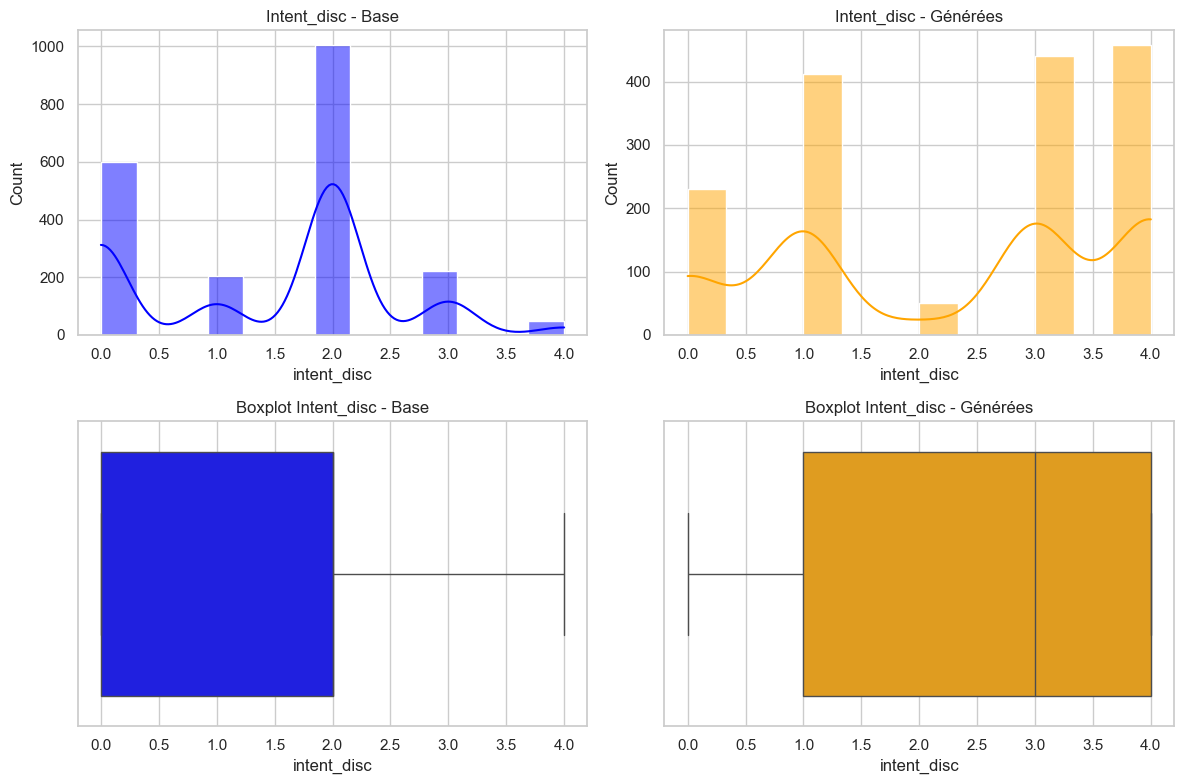

In [6]:
# Comparer la distribution des variables clés
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df_base_clean['intent_disc'], kde=True, ax=axes[0,0], color='blue')
axes[0,0].set_title('Intent_disc - Base')
sns.histplot(df_gen_clean['intent_disc'], kde=True, ax=axes[0,1], color='orange')
axes[0,1].set_title('Intent_disc - Générées')
sns.boxplot(x=df_base_clean['intent_disc'], ax=axes[1,0], color='blue')
axes[1,0].set_title('Boxplot Intent_disc - Base')
sns.boxplot(x=df_gen_clean['intent_disc'], ax=axes[1,1], color='orange')
axes[1,1].set_title('Boxplot Intent_disc - Générées')
plt.tight_layout()
plt.show()

In [7]:
# Calculer des métriques de similarité ou de divergence
def js_distance(a, b):
    # Normaliser les distributions
    a = np.array(a.dropna())
    b = np.array(b.dropna())
    # Histogrammes normalisés
    hist_a, _ = np.histogram(a, bins=20, range=(min(a.min(), b.min()), max(a.max(), b.max())), density=True)
    hist_b, _ = np.histogram(b, bins=20, range=(min(a.min(), b.min()), max(a.max(), b.max())), density=True)
    # Ajouter un epsilon pour éviter les zéros
    hist_a += 1e-8
    hist_b += 1e-8
    jsd = jensenshannon(hist_a, hist_b)
    return jsd

jsd_disc = js_distance(df_base_clean['intent_disc'], df_gen_clean['intent_disc'])
jsd_cont = js_distance(df_base_clean['intent_cont'], df_gen_clean['intent_cont'])
print(f"Distance de Jensen-Shannon (intent_disc) : {jsd_disc:.4f}")
print(f"Distance de Jensen-Shannon (intent_cont) : {jsd_cont:.4f}")

# Corrélation (en prenant la taille minimale pour éviter les erreurs de dimension)
min_size = min(len(df_base_clean['intent_disc'].dropna()), len(df_gen_clean['intent_disc'].dropna()))
base_disc_sample = df_base_clean['intent_disc'].dropna().iloc[:min_size]
gen_disc_sample = df_gen_clean['intent_disc'].dropna().iloc[:min_size]
base_cont_sample = df_base_clean['intent_cont'].dropna().iloc[:min_size]
gen_cont_sample = df_gen_clean['intent_cont'].dropna().iloc[:min_size]

corr_disc = np.corrcoef(base_disc_sample, gen_disc_sample)[0,1]
corr_cont = np.corrcoef(base_cont_sample, gen_cont_sample)[0,1]
print(f"Corrélation intent_disc (sur {min_size} échantillons) : {corr_disc:.4f}")
print(f"Corrélation intent_cont (sur {min_size} échantillons) : {corr_cont:.4f}")
min_size = min(len(df_base_clean['intent_disc'].dropna()), len(df_gen_clean['intent_disc'].dropna()))
base_disc_sample = df_base_clean['intent_disc'].dropna().iloc[:min_size]
gen_disc_sample = df_gen_clean['intent_disc'].dropna().iloc[:min_size]
gen_disc_sample = df_gen_clean['intent_disc'].dropna().iloc[:min_size]
base_cont_sample = df_base_clean['intent_cont'].dropna().iloc[:min_size]
base_cont_sample = df_base_clean['intent_cont'].dropna().iloc[:min_size]
gen_cont_sample = df_gen_clean['intent_cont'].dropna().iloc[:min_size]
gen_cont_sample = df_gen_clean['intent_cont'].dropna().iloc[:min_size]

corr_disc = np.corrcoef(base_disc_sample, gen_disc_sample)[0,1]
corr_cont = np.corrcoef(base_cont_sample, gen_cont_sample)[0,1]
print(f"Corrélation (sur intent_disc {min_size} échantillons) : {corr_disc:.4f}")
print(f"Corrélation (sur intent_cont {min_size} échantillons) : {corr_cont:.4f}")

Distance de Jensen-Shannon (intent_disc) : 0.4840
Distance de Jensen-Shannon (intent_cont) : 0.5542
Corrélation intent_disc (sur 1592 échantillons) : 0.0642
Corrélation intent_cont (sur 1592 échantillons) : -0.1087
Corrélation (sur intent_disc 1592 échantillons) : 0.0642
Corrélation (sur intent_cont 1592 échantillons) : -0.1087


## Comparaison des distributions: classes (intent_disc) et valeurs (intent_cont)
Les graphiques ci-dessous comparent la distribution des classes (discrètes) et des valeurs continues entre les données de base et les données générées.

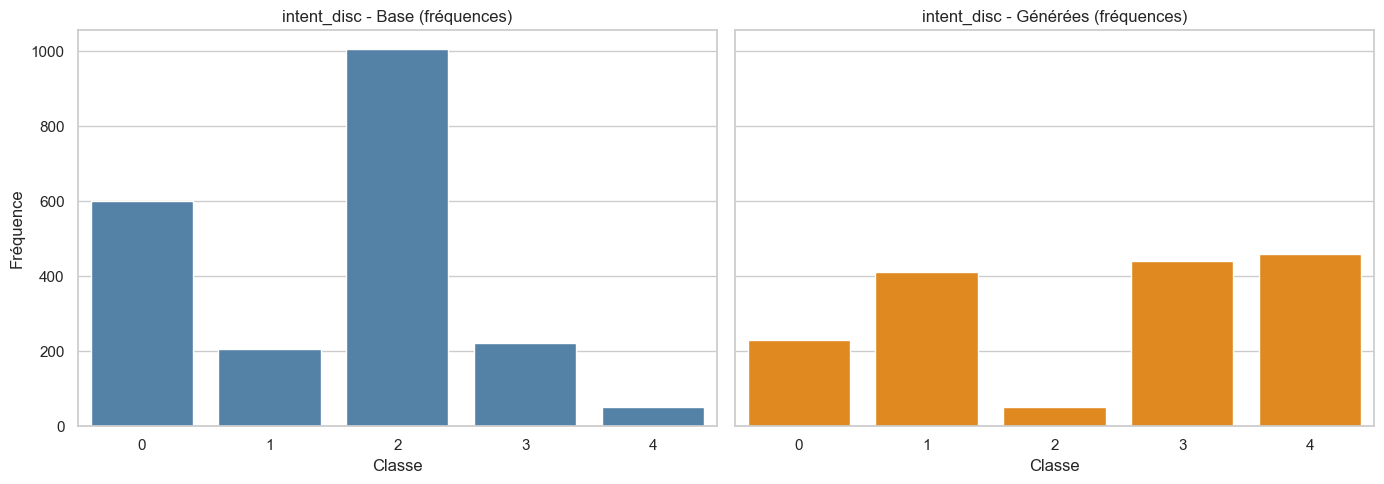

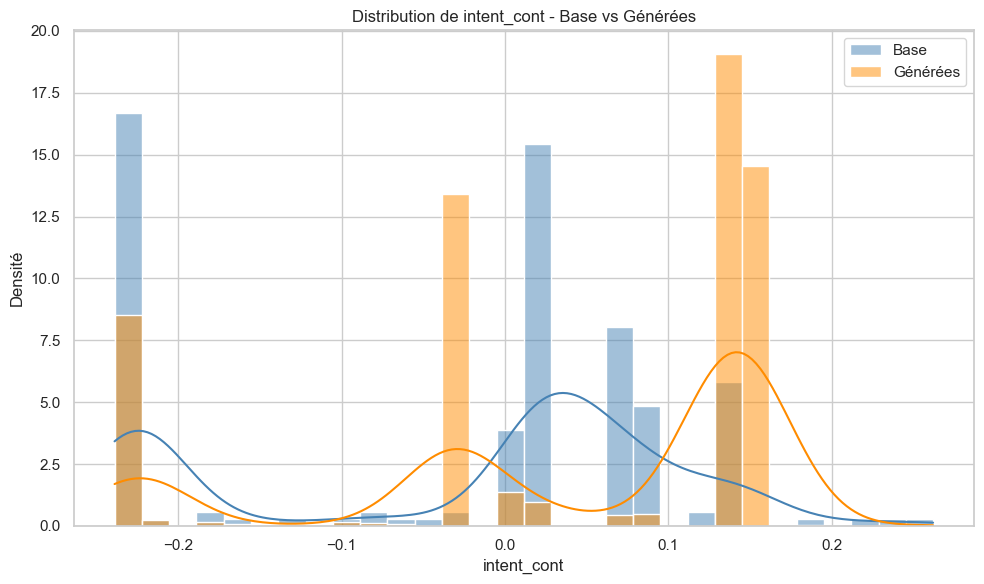

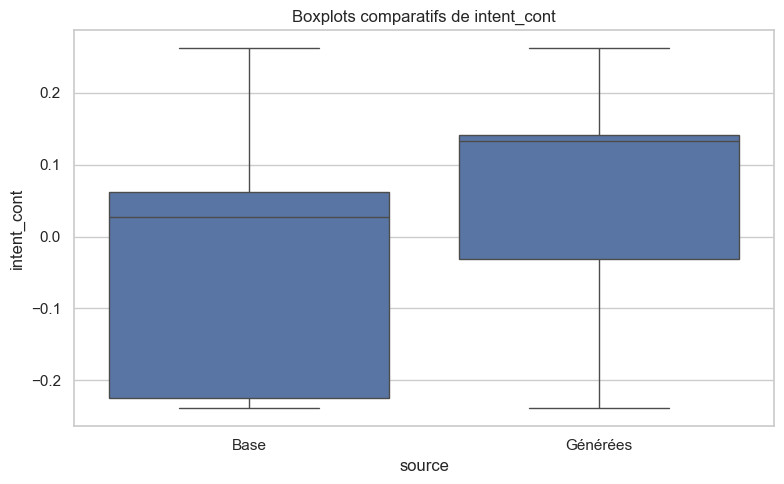

In [8]:
# Graphiques de comparaison des distributions
# 1) Distribution des classes (intent_disc) - barplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
base_counts = df_base_clean['intent_disc'].value_counts().sort_index()
gen_counts = df_gen_clean['intent_disc'].value_counts().sort_index()

# S'assurer des mêmes catégories sur l'axe x
all_classes = sorted(set(base_counts.index.dropna().tolist()) | set(gen_counts.index.dropna().tolist()))
base_counts = base_counts.reindex(all_classes, fill_value=0)
gen_counts = gen_counts.reindex(all_classes, fill_value=0)

sns.barplot(x=all_classes, y=base_counts.values, ax=axes[0], color='steelblue')
axes[0].set_title('intent_disc - Base (fréquences)')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Fréquence')

sns.barplot(x=all_classes, y=gen_counts.values, ax=axes[1], color='darkorange')
axes[1].set_title('intent_disc - Générées (fréquences)')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Fréquence')
plt.tight_layout()
plt.show()

# 2) Distribution des valeurs (intent_cont) - histogrammes + KDE superposés
plt.figure(figsize=(10,6))
sns.histplot(df_base_clean['intent_cont'], color='steelblue', label='Base', kde=True, stat='density', bins=30, alpha=0.5)
sns.histplot(df_gen_clean['intent_cont'], color='darkorange', label='Générées', kde=True, stat='density', bins=30, alpha=0.5)
plt.title('Distribution de intent_cont - Base vs Générées')
plt.xlabel('intent_cont')
plt.ylabel('Densité')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Boxplots comparatifs pour intent_cont
plt.figure(figsize=(8,5))
# Créer un DataFrame en format long pour seaborn
data_for_boxplot = pd.concat([
	pd.DataFrame({'values': df_base_clean['intent_cont'], 'source': 'Base'}),
	pd.DataFrame({'values': df_gen_clean['intent_cont'], 'source': 'Générées'})
], ignore_index=True)
sns.boxplot(data=data_for_boxplot, x='source', y='values')
plt.title('Boxplots comparatifs de intent_cont')
plt.ylabel('intent_cont')
plt.tight_layout()
plt.show()